In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


Data set from Twitter US Airline Sentiment
Analyze how travelers in February 2015 expressed their feelings on Twitter 
Available at: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [2]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569154129362186240,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,cwgreiner,NaN,0,@SouthwestAir my flight is Cancelled Flightled...,NaN,2015-02-21 07:18:13 -0800,NaN,NaN
1,570260387746029568,negative,0.6619,Late Flight,0.6619,Southwest,NaN,SMiles1307,NaN,0,@SouthwestAir Supposed to take off almost 2 ho...,NaN,2015-02-24 08:34:06 -0800,NaN,NaN
2,569188938012880896,negative,1.0000,Lost Luggage,1.0000,United,NaN,NewsLadiesNeed,NaN,0,@united Why do I still not have my bags? They ...,"[33.89638659, -84.33108377]",2015-02-21 09:36:32 -0800,Atlanta,Eastern Time (US & Canada)
3,569130479690981376,negative,1.0000,Customer Service Issue,0.6758,United,NaN,DiqM,NaN,0,"@united web app won't let me upgrade seats, ca...",NaN,2015-02-21 05:44:14 -0800,here,Mountain Time (US & Canada)
4,567924953976152064,negative,1.0000,Lost Luggage,1.0000,United,NaN,ColtSTaylor,NaN,0,@united I want my bags. There is vital equipme...,"[33.75539049, -116.36196163]",2015-02-17 21:53:55 -0800,All Over The World,NaN


It has 15 features but for this project it needs only two features. 

In [3]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,negative,@SouthwestAir my flight is Cancelled Flightled...
1,negative,@SouthwestAir Supposed to take off almost 2 ho...
2,negative,@united Why do I still not have my bags? They ...
3,negative,"@united web app won't let me upgrade seats, ca..."
4,negative,@united I want my bags. There is vital equipme...


#### Data Visualization

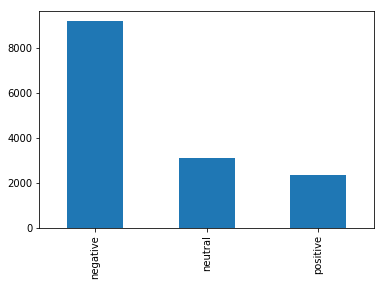

In [4]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

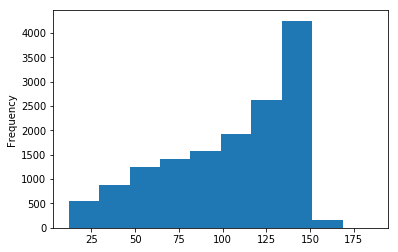

In [5]:
data['text'].str.len().plot.hist()

#### Data Preprocessing

In [6]:
data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,negative,@SouthwestAir my flight is Cancelled Flightled...
1,negative,@SouthwestAir Supposed to take off almost 2 ho...
2,negative,@united Why do I still not have my bags? They ...
3,negative,"@united web app won't let me upgrade seats, ca..."
4,negative,@united I want my bags. There is vital equipme...


In [8]:
data['text'].apply(lambda x: x.lower()) 
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0    SouthwestAir my flight is Cancelled Flightled ...
1    SouthwestAir Supposed to take off almost 2 hou...
2    united Why do I still not have my bags They ar...
3    united web app wont let me upgrade seats call ...
4    united I want my bags There is vital equipment...
Name: text, dtype: object

In [10]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,   11,    8,   14,   37,   82,  161,    1,  129,   57,  172],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   16,  388,    1,  147,  136,  362,   60,   56],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           5,   69,   43,    3,   72,   24,   22,   11,  141,   54,  564,
        2723,  253,  623,   72,   27,    2,  396,   56,   95,  237, 1429],
       [   0,    0,    0,    0,    0,    0,    0,    5,  980,  315,  210,
         198,   19,  339,  190,   83, 1027,  121,   47,   14,  356,  137,
         540,   41,  144,    1,   30,   98, 1430,   31,   64,    4, 4604],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           5,    3,  144,   11,  1

pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

#### Model

In [11]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [13]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Training The Model

In [15]:
batch_size = 32
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 136s - loss: 0.6537 - acc: 0.7311
Epoch 2/10
 - 137s - loss: 0.4430 - acc: 0.8317
Epoch 3/10
 - 136s - loss: 0.3624 - acc: 0.8621
Epoch 4/10
 - 136s - loss: 0.3010 - acc: 0.8877
Epoch 5/10
 - 146s - loss: 0.2474 - acc: 0.9089
Epoch 6/10
 - 137s - loss: 0.2109 - acc: 0.9232
Epoch 7/10
 - 151s - loss: 0.1866 - acc: 0.9331
Epoch 8/10
 - 185s - loss: 0.1558 - acc: 0.9425
Epoch 9/10
 - 142s - loss: 0.1418 - acc: 0.9490
Epoch 10/10
 - 139s - loss: 0.1151 - acc: 0.9571


In [16]:
model.save('sentiment_analysis.h5')

####  Testing Model

In [17]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

SouthwestAir my flight is Cancelled Flightled due to weather What next  [9.9956995e-01 3.8048709e-04 4.9512411e-05] [1 0 0]
SouthwestAir Supposed to take off almost 2 hours agovacationfail frozenwater gettingimpatient theycouldatleastofferfreebooze [9.9880040e-01 1.1416686e-03 5.7845002e-05] [1 0 0]
united Why do I still not have my bags They arrived 10AM ampwebsite says theyre still at the airport2 12 hours Late Flightr nothappy [9.9996817e-01 2.5809910e-05 6.0088264e-06] [1 0 0]
united web app wont let me upgrade seats call center wait time is 20 minutes plus just want to get more legroom but its a pita [0.8465566  0.08724797 0.06619544] [1 0 0]
united I want my bags There is vital equipment in there You are royally screwing me Im cranky and want an update [0.00344052 0.17075147 0.825808  ] [0 1 0]


[None, None, None, None, None]